In [12]:
"""
image generation: MNIST veri seti
"""
# kutuphanelerin import edilmesi
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# %% veriseti hazirlama
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# min batch boyutu
batch_size = 128

# goruntu boyutu
image_size = 28*28

transform = transforms.Compose([
    # goruntuleri tensore cevir
    transforms.ToTensor(),
    # Normalizasyon -> -1 ile 1 arasina sikistir
    transforms.Normalize((0.5,),(0.5,))])


In [14]:
# MNIST verisetini yukleme
dataset = datasets.MNIST(root='./data', train=True, transform=transform,
                         download=True)

# verisetini batchler halinde yukle
dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
# %% discriminator olustur

# Ayirt edici: Generator un uretmis oldugu goruntulerin gercek mi sahte mi 
# oldugunu ayirt edecek

class discriminator(nn.Module):

    def __init__(self):
        super(discriminator,self).__init__()
        self.model = nn.Sequential(
            # input = image size
            # 1024 = boron sayisi yani output sayisi
            nn.Linear(image_size, 1024),
            # aktivasyon fonksiyonu ve 0.2'lik egim
            nn.LeakyReLU(0.2),
            # 1024 den 512 lik dugume
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            # 512 den 256 ya
            nn.Linear(512, 256),
            nn.ReLU(0.2),
            # output layer oldugundan dolayi 256 -> 1 (cikti sonucu: gercek veya sahte mi seklinde)
            nn.Linear(256, 1),
            # ciktiyi 0-1 arasina kesirli bir ifade biciminde olasiliksal olarak ifade eder
            nn.Sigmoid()
        )

    def forward(self, image):
        # goruntuyu duzlestirerek modele veriyoruz
        return self.model(image.view(-1, image_size))

In [16]:
# %% generator olustur

# goruntu olsuturmak icin tanimlanan generator sinifi (class)
class generator(nn.Module):
    def __init__(self, z_dim):
        super(generator, self).__init__()
        self.model = nn.Sequential(
            # giristen 256 dugume tam bagli katman
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            # 256'dan 512 dugume 256 -> 512
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            # 1024'ten image_size (784) e cevrim
            nn.Linear(1024,image_size),
            # cikis atkivasyon foksiyonu
            nn.Tanh()
        )
    def forward(self, x):
        # ciktiyi 28x28'lik goruntuye ceviriyoruz
        return self.model(x).view(-1,1,28,28)

In [17]:
# %% gan training

# hyper parameters tanimliyoruz
# learning rate
lr = 0.0002

# rastgele gurultu vektor boyutu (noise goruntusu)
z_dim = 100

# egitim dongu sayisi
epochs = 20

# model baslatma: generator ve discriminator tanimlama
generator = generator(z_dim).to(device)

discriminator = discriminator().to(device)

# kayip fonksiyonu ve optimizasyon algoritmalasrinin tanimlanmasi
# binary cross entropy
criterion = nn.BCELoss()

# generator optimizer
g_optimizer = optim.Adam(generator.parameters(), lr=lr,betas=(0.5,0.999))

# discriminator optimizer
d_optimizer = optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))

# egitim dongusunun baslatilmasi
for epoch in range(epochs):
    # gotuntulerin yuklenmesi
    for i , (real_imgs, _) in enumerate(dataLoader):
    
        # discriminator egitimi
        real_imgs = real_imgs.to(device)
        
        # mevcut batchin boyutunu al %99
        # mevcut gorsel boyutlarinin 469*128 olmasi 468*128 ile farki 
        # alindiginda geriye 96 klair batch olan 128 tamamlanmaz
        batch_size = real_imgs.size(0) # [128, 28, 28]
        
        # gercek goruntuleri 1 olarak etiketle
        real_labels = torch.ones(batch_size,1).to(device)
        
        # sahte goruntuleri 0 olarak etiketle
        fake_labels = torch.zeros(batch_size,1).to(device)

        # discriminator egitimi
        
        # rastgele gurultu uret
        z = torch.randn(batch_size,z_dim).to(device)
        
        # generator ile sahte goruntu olustur
        fake_imgs = generator(z)

        # gercek goruntu kaybini hesapla
        real_loss = criterion(discriminator(real_imgs), real_labels)

        # sahte goruntu kaybini hesapla 
        fake_loss = criterion(discriminator(fake_imgs.detach()),fake_labels)

        # toplam discriminator kaybi
        d_loss = real_loss + fake_loss

        # gradyanlari sifirla
        d_optimizer.zero_grad()
        # geriye yayilim
        d_loss.backward()
        # parametreleri guncelle
        d_optimizer.step()

        # generator egitilmesi
        # generator kaybi 
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    print(f'Epoch: {epoch +1}/{epochs} d_loss: {d_loss.item():.3f}, g_loss: {g_loss.item():.3f}')

Epoch: 1/20 d_loss: 0.333, g_loss: 3.186
Epoch: 2/20 d_loss: 0.293, g_loss: 6.103
Epoch: 3/20 d_loss: 0.384, g_loss: 3.375
Epoch: 4/20 d_loss: 0.479, g_loss: 3.421
Epoch: 5/20 d_loss: 0.397, g_loss: 4.473
Epoch: 6/20 d_loss: 0.244, g_loss: 3.748
Epoch: 7/20 d_loss: 0.370, g_loss: 2.165
Epoch: 8/20 d_loss: 0.549, g_loss: 2.408
Epoch: 9/20 d_loss: 0.461, g_loss: 2.084
Epoch: 10/20 d_loss: 1.687, g_loss: 0.941
Epoch: 11/20 d_loss: 0.655, g_loss: 1.443
Epoch: 12/20 d_loss: 0.846, g_loss: 1.500
Epoch: 13/20 d_loss: 0.824, g_loss: 1.285
Epoch: 14/20 d_loss: 0.829, g_loss: 1.219
Epoch: 15/20 d_loss: 0.944, g_loss: 1.734
Epoch: 16/20 d_loss: 0.819, g_loss: 1.445
Epoch: 17/20 d_loss: 0.859, g_loss: 1.416
Epoch: 18/20 d_loss: 1.041, g_loss: 1.864
Epoch: 19/20 d_loss: 0.885, g_loss: 2.100
Epoch: 20/20 d_loss: 0.874, g_loss: 1.424


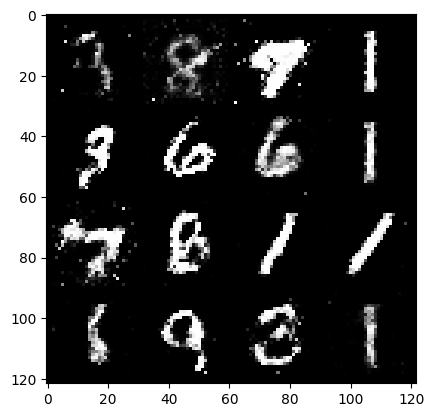

In [18]:
# model testing and performance evaluation
# rastgele gurultu ile goruntu olusturma
with torch.no_grad():
    # 16 adet rastgele gurultu olustur
    z = torch.randn(16, z_dim).to(device)
    # generator ile sahte goruntu olusturma
    sample_imgs = generator(z).cpu()
    # goruntuleri izgara gorunumuınde duzenle
    grid = np.transpose(utils.make_grid(sample_imgs, nrow=4, normalize=True),(1,2,0))
    plt.imshow(grid)
    plt.show()
